In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import rm
from xgboost import plot_importance
import shap

import warnings
warnings.filterwarnings('ignore')

path_csv = "../../../Thesis_data/processed_data/"
path_model = "../../../Thesis_data/Models/"

In [5]:
X_test_unscaled = pd.read_csv(path_csv + "ontime_reporting_X_test_unscaled.csv")
X_test = rm(pd.read_csv(path_csv + "ontime_reporting_X_test.csv"))
y_test = np.ravel(pd.read_csv(path_csv + "ontime_reporting_y_test.csv"))

Memory usage of dataframe is 314.23 MB
Memory usage after optimization is: 78.56 MB
Decreased by 75.0%


In [24]:
#Load airline full names
airlines = pd.read_csv("../_1. Data Preprocessing/UNIQUE_CARRIERS.csv")

In [26]:
#Load best model
xgb_class_tuned_ros = joblib.load(path_model + "XGBoost_tuned_ROSRUS.joblib")
y_pred_xgb_tuned_ros = xgb_class_tuned_ros.predict(X_test)

y_diff = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_xgb_tuned_ros})
y_diff['Difference'] = np.where(y_diff['y_test'] == y_diff['y_pred'], 0, 1) #0 means no difference, 1 means a difference
merged_df = X_test_unscaled.merge(y_diff, left_index=True, right_index=True)
merged_df = merged_df.merge(airlines, left_on="OP_UNIQUE_CARRIER", right_on="Code")

In [ ]:
# df_filtered = merged_df[merged_df["Difference"] == 1]

# counts = df_filtered.groupby("Description")["Difference"].count()
# counts = counts.sort_values(ascending=False)

# plt.figure(figsize=(10, 6))
# counts.plot(kind="bar")
# #plt.title("Count of 1s in binary_column per Airline")
# plt.xlabel("Airlines")
# plt.ylabel("Counts of prediction errors")
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
# df_filtered = merged_df[merged_df["Difference"] == 1]

# counts = df_filtered.groupby("OP_UNIQUE_CARRIER")["Difference"].count()
# counts = counts.sort_values(ascending=False)

# total_counts = merged_df.groupby("Description").size()

# combined_counts = pd.concat([counts, total_counts], axis=1)
# combined_counts.columns = ["Count of 1s", "Total Count"]

# plt.figure(figsize=(10, 6))
# combined_counts.plot(kind="bar", width=0.7)
# plt.title("Comparison of Counts for Each Airline")
# plt.xlabel("Airlines")
# plt.ylabel("Counts")
# plt.xticks(rotation=45)
# plt.show()

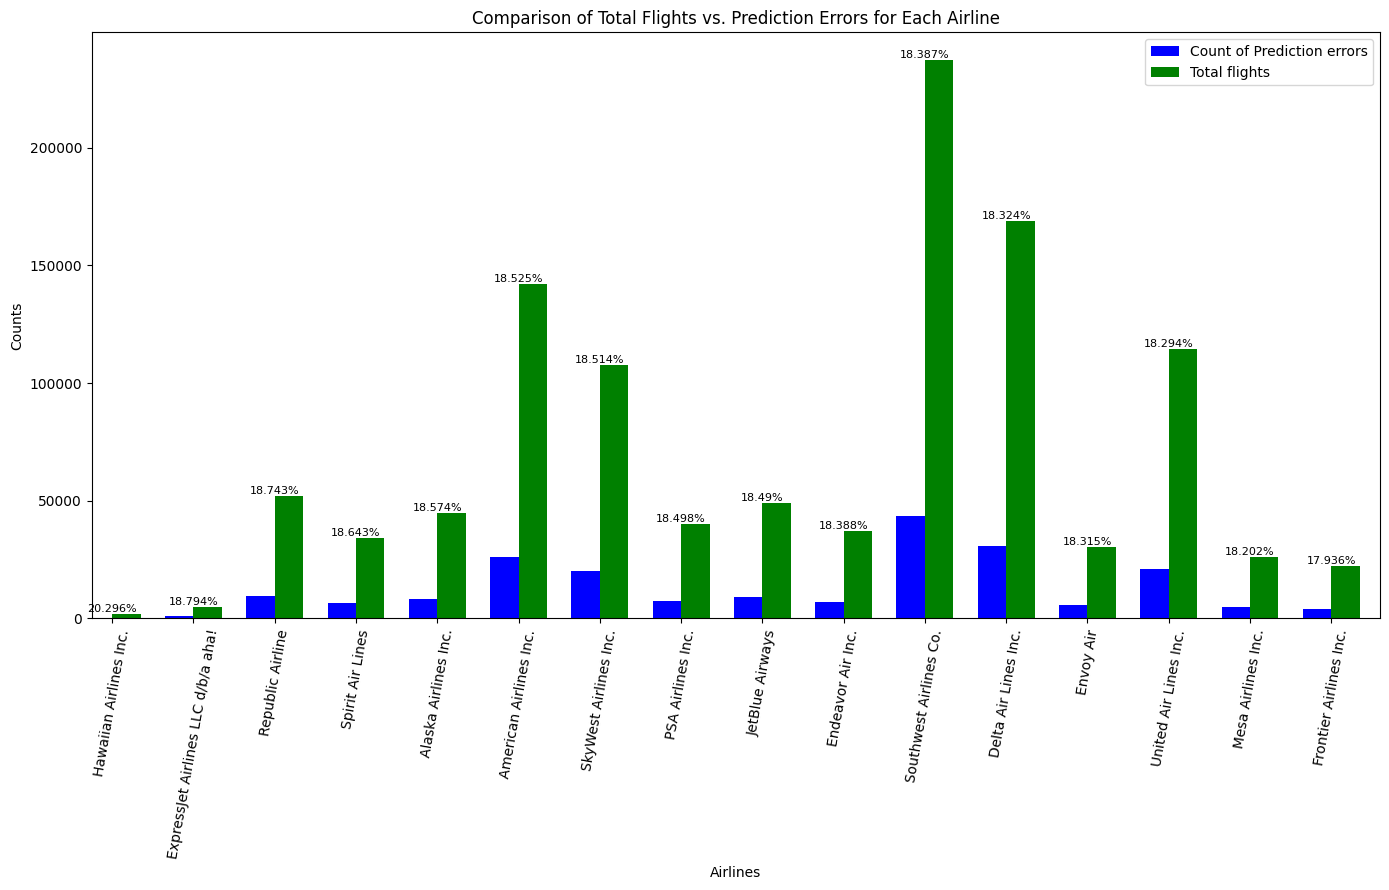

In [37]:
df_filtered = merged_df[merged_df["Difference"] == 1]

counts = df_filtered.groupby("Description")["Difference"].count()
counts = counts.sort_values(ascending=False)

total_counts = merged_df.groupby("Description").size()

combined_counts = pd.concat([counts, total_counts], axis=1)
combined_counts.columns = ["Count of Prediction errors", "Total flights"]

def calculate_error_percentage(row):
    return round(((row['Count of Prediction errors'] / row['Total flights']) * 100), 3)

combined_counts['error_percentage'] = combined_counts.apply(calculate_error_percentage, axis=1)

combined_counts = combined_counts.sort_values(by='error_percentage', ascending=False)

plt.figure(figsize=(14, 9))

combined_counts['Count of Prediction errors'].plot(kind="bar", width=0.35, position=1, color='b', align='center', label='Count of Prediction errors')
combined_counts['Total flights'].plot(kind="bar", width=0.35, position=0, color='g', align='center', label='Total flights')

for i, value in enumerate(combined_counts['error_percentage']):
    plt.text(i, max(combined_counts['Count of Prediction errors'][i], combined_counts['Total flights'][i]) + 10, f"{value}%", ha='center', va='bottom', fontsize=8)

plt.title("Comparison of Total Flights vs. Prediction Errors for Each Airline")
plt.xlabel("Airlines")
plt.ylabel("Counts")
plt.xticks(range(len(combined_counts.index)), combined_counts.index, rotation=80)
plt.legend()
plt.tight_layout()
plt.show()

## Top 10 feature importance per model

## Logistic regression

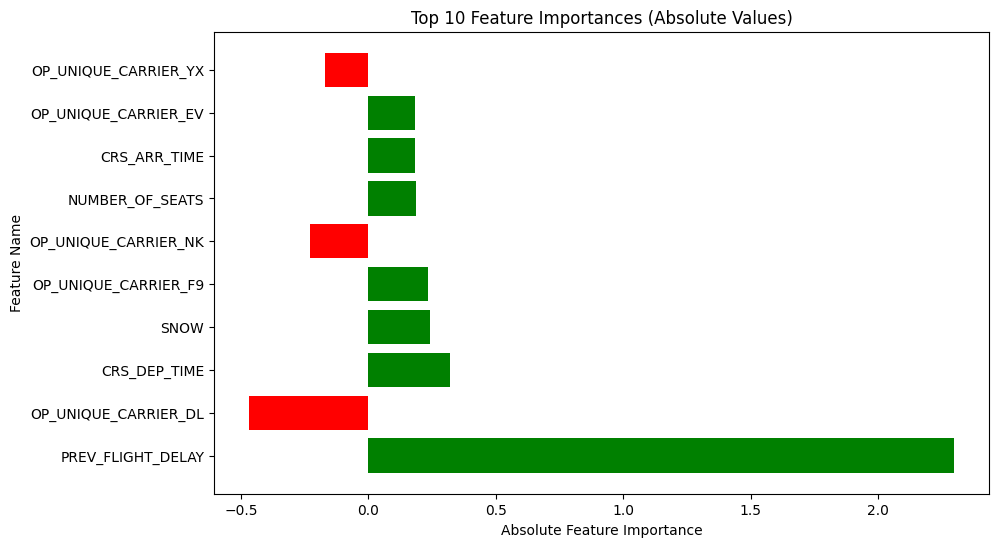

In [30]:
logreg_tuned_imbalance = joblib.load(path_model + "logreg_tuned_ROSRUS.joblib")
top_indices = np.argsort(np.abs(logreg_tuned_imbalance.coef_[0]))[::-1][:10]

top_feature_names = [logreg_tuned_imbalance.feature_names_in_[i] for i in top_indices]
top_feature_coefficients = logreg_tuned_imbalance.coef_[0][top_indices]

top_feature_signs = np.sign(top_feature_coefficients)

plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_feature_coefficients, color=np.where(top_feature_signs == 1, 'g', 'r'))
plt.xlabel('Absolute Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Importances (Absolute Values)')
plt.show()

## XGBoost

C:\Users\Rvanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:160: UserWarning: [19:41:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x600 with 0 Axes>

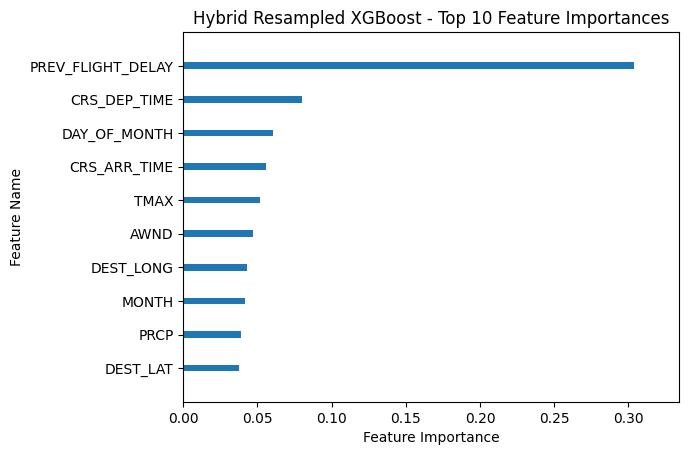

In [1]:
import joblib
import matplotlib.pyplot as plt
from xgboost import plot_importance

path_model = "../../../Thesis_data/Models/"
xgb_class_tuned_ros = joblib.load(path_model + "XGBoost_tuned_ROSRUS.joblib")

# Get the feature importance values
importance_values = xgb_class_tuned_ros.get_booster().get_score(importance_type='total_gain')

# Calculate the sum of all importance values
total_importance = sum(importance_values.values())

# Rescale the importance values to ensure they sum up to 1
rescaled_importance = {key: value / total_importance for key, value in importance_values.items()}

plt.figure(figsize=(10, 6))
ax = plot_importance(rescaled_importance, max_num_features=10, show_values=False)
ax.grid(False)  # Disable gridlines
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Hybrid Resampled XGBoost - Top 10 Feature Importances')
plt.show()

<Figure size 1000x600 with 0 Axes>

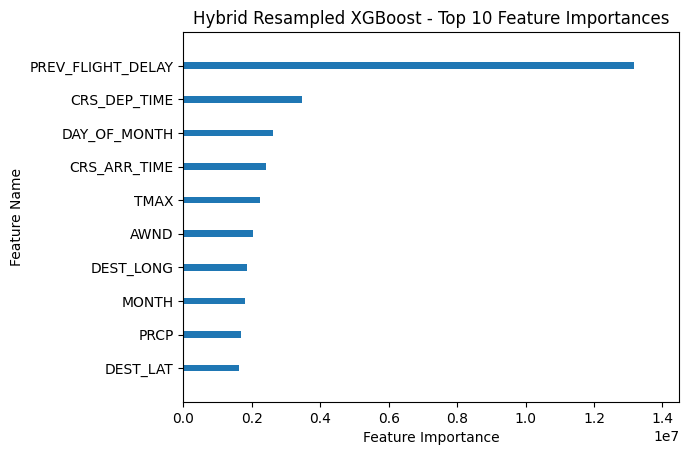

In [11]:
import joblib
import matplotlib.pyplot as plt
from xgboost import plot_importance
path_model = "../../../Thesis_data/Models/"
xgb_class_tuned_ros = joblib.load(path_model + "XGBoost_tuned_ROSRUS.joblib")

plt.figure(figsize=(10, 6))
ax = plot_importance(xgb_class_tuned_ros.get_booster().get_score(importance_type='total_gain'), max_num_features=10, show_values=False) #weight, total_gain
ax.grid(False)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Hybrid Resampled XGBoost - Top 10 Feature Importances')
plt.show()

## TabNet

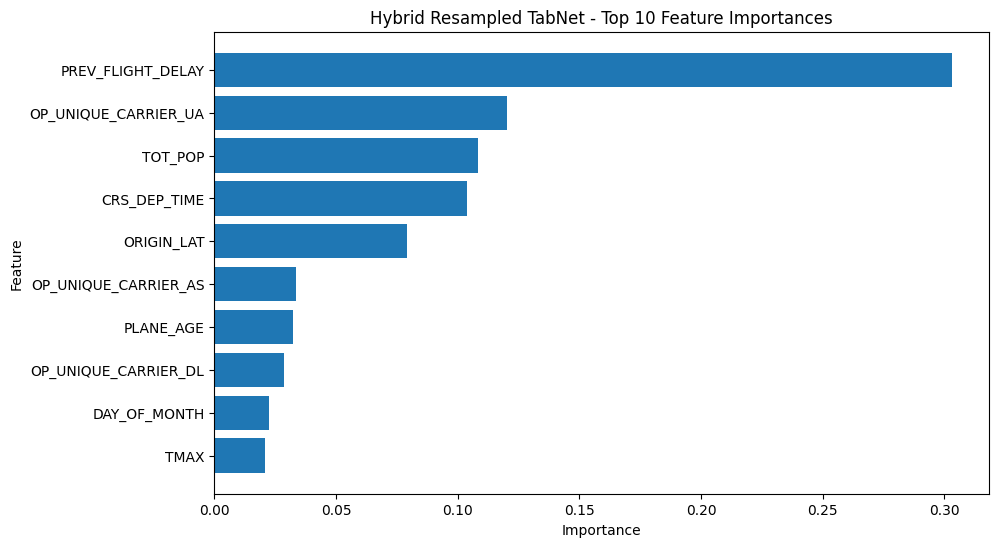

In [6]:
import torch
import pandas as pd
tabnet_tuned_rosrus = torch.load(path_model + "TabNet_tuned_ROSRUS.pt", map_location=torch.device('cpu'))
feature_importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': tabnet_tuned_rosrus.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_10_features = feature_importance_df.head(10)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Hybrid Resampled TabNet - Top 10 Feature Importances')
plt.show()

## Random Forests

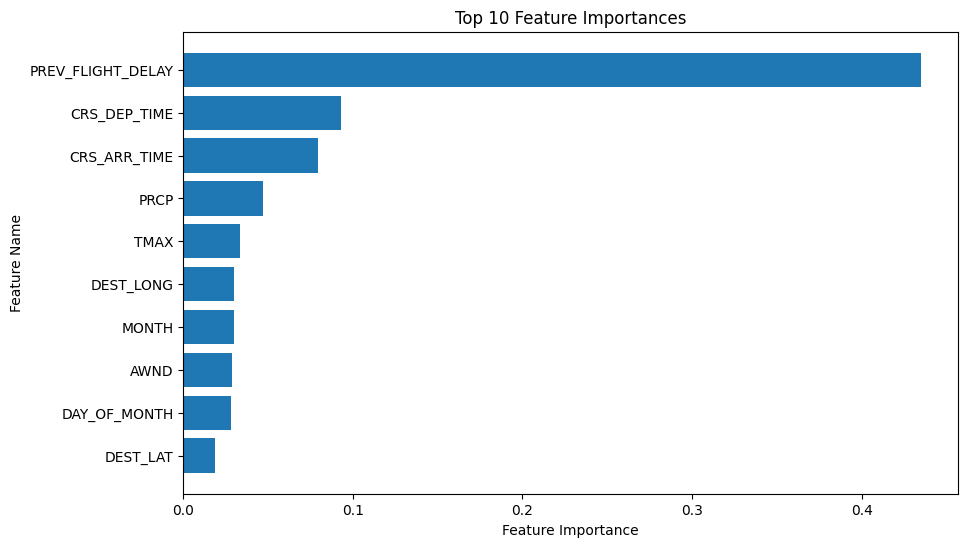

In [32]:
rf_tuned_rosrus = joblib.load(path_model + "rf_tuned_ROSRUS.joblib")
top_indices = np.argsort(rf_tuned_rosrus.feature_importances_)[::-1][:10]
top_feature_names = [rf_tuned_rosrus.feature_names_in_[i] for i in top_indices]
top_feature_importances = rf_tuned_rosrus.feature_importances_[top_indices]
top_feature_names.reverse()
top_feature_importances = np.flip(top_feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Importances')
plt.show()